# Chesspieces Project






## Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install ax-platform

     |████████████████████████████████| 993 kB 5.3 MB/s 
     |████████████████████████████████| 363 kB 64.0 MB/s 
     |████████████████████████████████| 713 kB 54.2 MB/s 
     |████████████████████████████████| 310 kB 62.3 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=3cbbec1766d637baac4034eecbb4954760758a0fe40af5966218b4158d3313e3
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


## Import relevant pacages

In [ ]:
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torchvision.transforms.transforms import ToTensor
import torchvision.models as models

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

from collections import OrderedDict
from functools import partial
from typing import Callable, Optional

from torchvision.transforms.transforms import RandomVerticalFlip
import os
import json
import sys

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from prettytable import PrettyTable

## Confusion Matrix

In [ ]:
# Define Confusion Matrix Class
class ConfusionMatrix(object):
    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.labels = labels
    
    # Update Matrix.
    def update(self, preds, labels):
        for p, t in zip(preds, labels):
            self.matrix[p, t] += 1
    # Show Result(Words)
    def summary(self):
        # calculate accuracy
        sum_TP = 0
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]
        acc = sum_TP / np.sum(self.matrix)
        print("the model accuracy is ", acc)

        # precision, recall, specificity
        table = PrettyTable()
        table.field_names = ["", "Precision", "Recall", "Specificity"]
        for i in range(self.num_classes):
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN
            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
            table.add_row([self.labels[i], Precision, Recall, Specificity])
        print(table)

    # Plot
    def plot(self):
        matrix = self.matrix
        # print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        # Set Xlabel
        plt.xticks(range(self.num_classes), self.labels, rotation=45)
        # Set Ylabel
        plt.yticks(range(self.num_classes), self.labels)
        # Colorbar
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix')

        # Add classification results into matrix
        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()

## Load Data

In [ ]:
# Model preporcessing

# Set Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using {} for this project'.format(device))

# Image_Loader and Label
# path_root = '/Users/maojietang/Downloads/Image_Segmentation-main/deep-learning-for-image-processing-master'
path_root = '/content/drive/MyDrive/Data'
image_path = os.path.join(path_root, 'data_642_3')
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)


img_size = {"s": [300, 384],  # train_size, val_size
            "m": [384, 480],
            "l": [384, 480]}
num_model = "s"

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(img_size[num_model][0]),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    "val": transforms.Compose([transforms.Resize(img_size[num_model][1]),
                                transforms.CenterCrop(img_size[num_model][1]),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])}

# Get train_set
train_dataset = datasets.ImageFolder(root=os.path.join(image_path, 'train'),
                                      transform=data_transform['train'])
train_num = len(train_dataset)

# Get label
category_to_label = train_dataset.class_to_idx
label_to_category = dict((val, key) for key, val in category_to_label.items())

# Write to json
json_label = json.dumps(label_to_category, indent=4)
with open('class_label.json', 'w') as json_file:
    json_file.write(json_label)

# Load train_loader / val_loader
batch_size = 32
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=nw)
batch_num = len(train_loader)

val_dataset = datasets.ImageFolder(root=os.path.join(image_path, 'val'),
                                    transform=data_transform['val'])
val_num = len(val_dataset)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=32,
                                          shuffle=False,
                                          num_workers=nw)

Using cuda:0 for this project


## Model (EfficientNetV2)

In [ ]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    "Deep Networks with Stochastic Depth", https://arxiv.org/pdf/1603.09382.pdf

    This function is taken from the rwightman.
    It can be seen here:
    https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py#L140
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    "Deep Networks with Stochastic Depth", https://arxiv.org/pdf/1603.09382.pdf
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class ConvBNAct(nn.Module):
    def __init__(self,
                 in_planes: int,
                 out_planes: int,
                 kernel_size: int = 3,
                 stride: int = 1,
                 groups: int = 1,
                 norm_layer: Optional[Callable[..., nn.Module]] = None,
                 activation_layer: Optional[Callable[..., nn.Module]] = None):
        super(ConvBNAct, self).__init__()

        padding = (kernel_size - 1) // 2
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if activation_layer is None:
            activation_layer = nn.SiLU  # alias Swish  (torch>=1.7)

        self.conv = nn.Conv2d(in_channels=in_planes,
                              out_channels=out_planes,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding,
                              groups=groups,
                              bias=False)

        self.bn = norm_layer(out_planes)
        self.act = activation_layer()

    def forward(self, x):
        result = self.conv(x)
        result = self.bn(result)
        result = self.act(result)

        return result


class SqueezeExcite(nn.Module):
    def __init__(self,
                 input_c: int,   # block input channel
                 expand_c: int,  # block expand channel
                 se_ratio: float = 0.25):
        super(SqueezeExcite, self).__init__()
        squeeze_c = int(input_c * se_ratio)
        self.conv_reduce = nn.Conv2d(expand_c, squeeze_c, 1)
        self.act1 = nn.SiLU()  # alias Swish
        self.conv_expand = nn.Conv2d(squeeze_c, expand_c, 1)
        self.act2 = nn.Sigmoid()

    def forward(self, x: Tensor) -> Tensor:
        scale = x.mean((2, 3), keepdim=True)
        scale = self.conv_reduce(scale)
        scale = self.act1(scale)
        scale = self.conv_expand(scale)
        scale = self.act2(scale)
        return scale * x


class MBConv(nn.Module):
    def __init__(self,
                 kernel_size: int,
                 input_c: int,
                 out_c: int,
                 expand_ratio: int,
                 stride: int,
                 se_ratio: float,
                 drop_rate: float,
                 norm_layer: Callable[..., nn.Module]):
        super(MBConv, self).__init__()

        if stride not in [1, 2]:
            raise ValueError("illegal stride value.")

        self.has_shortcut = (stride == 1 and input_c == out_c)

        activation_layer = nn.SiLU  # alias Swish
        expanded_c = input_c * expand_ratio

        # conv_pw
        assert expand_ratio != 1
        # Point-wise expansion
        self.expand_conv = ConvBNAct(input_c,
                                     expanded_c,
                                     kernel_size=1,
                                     norm_layer=norm_layer,
                                     activation_layer=activation_layer)

        # Depth-wise convolution
        self.dwconv = ConvBNAct(expanded_c,
                                expanded_c,
                                kernel_size=kernel_size,
                                stride=stride,
                                groups=expanded_c,
                                norm_layer=norm_layer,
                                activation_layer=activation_layer)

        self.se = SqueezeExcite(input_c, expanded_c, se_ratio) if se_ratio > 0 else nn.Identity()

        # Point-wise linear projection
        self.project_conv = ConvBNAct(expanded_c,
                                      out_planes=out_c,
                                      kernel_size=1,
                                      norm_layer=norm_layer,
                                      activation_layer=nn.Identity)  # to identity func

        self.out_channels = out_c

        # dropout for shorcut
        self.drop_rate = drop_rate
        if self.has_shortcut and drop_rate > 0:
            self.dropout = DropPath(drop_rate)

    def forward(self, x: Tensor) -> Tensor:
        result = self.expand_conv(x)
        result = self.dwconv(result)
        result = self.se(result)
        result = self.project_conv(result)

        if self.has_shortcut:
            if self.drop_rate > 0:
                result = self.dropout(result)
            result += x

        return result


class FusedMBConv(nn.Module):
    def __init__(self,
                 kernel_size: int,
                 input_c: int,
                 out_c: int,
                 expand_ratio: int,
                 stride: int,
                 se_ratio: float,
                 drop_rate: float,
                 norm_layer: Callable[..., nn.Module]):
        super(FusedMBConv, self).__init__()

        assert stride in [1, 2]
        assert se_ratio == 0

        self.has_shortcut = stride == 1 and input_c == out_c
        self.drop_rate = drop_rate

        self.has_expansion = expand_ratio != 1

        activation_layer = nn.SiLU  # alias Swish
        expanded_c = input_c * expand_ratio

        # expand ratio != 1 -> expand
        if self.has_expansion:
            # Expansion convolution
            self.expand_conv = ConvBNAct(input_c,
                                         expanded_c,
                                         kernel_size=kernel_size,
                                         stride=stride,
                                         norm_layer=norm_layer,
                                         activation_layer=activation_layer)

            self.project_conv = ConvBNAct(expanded_c,
                                          out_c,
                                          kernel_size=1,
                                          norm_layer=norm_layer,
                                          activation_layer=nn.Identity) 
        else:
            # for project_conv
            self.project_conv = ConvBNAct(input_c,
                                          out_c,
                                          kernel_size=kernel_size,
                                          stride=stride,
                                          norm_layer=norm_layer,
                                          activation_layer=activation_layer)

        self.out_channels = out_c

        # dropout for shorcut
        self.drop_rate = drop_rate
        if self.has_shortcut and drop_rate > 0:
            self.dropout = DropPath(drop_rate)

    def forward(self, x: Tensor) -> Tensor:
        if self.has_expansion:
            result = self.expand_conv(x)
            result = self.project_conv(result)
        else:
            result = self.project_conv(x)

        if self.has_shortcut:
            if self.drop_rate > 0:
                result = self.dropout(result)

            result += x

        return result


class EfficientNetV2(nn.Module):
    def __init__(self,
                 model_cnf: list,
                 num_classes: int = 1000,
                 num_features: int = 1280,
                 dropout_rate: float = 0.2,
                 drop_connect_rate: float = 0.2):
        super(EfficientNetV2, self).__init__()

        for cnf in model_cnf:
            assert len(cnf) == 8

        norm_layer = partial(nn.BatchNorm2d, eps=1e-3, momentum=0.1)

        stem_filter_num = model_cnf[0][4]

        self.stem = ConvBNAct(3,
                              stem_filter_num,
                              kernel_size=3,
                              stride=2,
                              norm_layer=norm_layer)  # SiLU function

        total_blocks = sum([i[0] for i in model_cnf])
        block_id = 0
        blocks = []
        for cnf in model_cnf:
            repeats = cnf[0]
            op = FusedMBConv if cnf[-2] == 0 else MBConv
            for i in range(repeats):
                blocks.append(op(kernel_size=cnf[1],
                                 input_c=cnf[4] if i == 0 else cnf[5],
                                 out_c=cnf[5],
                                 expand_ratio=cnf[3],
                                 stride=cnf[2] if i == 0 else 1,
                                 se_ratio=cnf[-1],
                                 drop_rate=drop_connect_rate * block_id / total_blocks,
                                 norm_layer=norm_layer))
                block_id += 1
        self.blocks = nn.Sequential(*blocks)

        head_input_c = model_cnf[-1][-3]
        head = OrderedDict()

        head.update({"project_conv": ConvBNAct(head_input_c,
                                               num_features,
                                               kernel_size=1,
                                               norm_layer=norm_layer)})  # SiLU function

        head.update({"avgpool": nn.AdaptiveAvgPool2d(1)})
        head.update({"flatten": nn.Flatten()})

        if dropout_rate > 0:
            head.update({"dropout": nn.Dropout(p=dropout_rate, inplace=True)})
        head.update({"classifier": nn.Linear(num_features, num_classes)})

        self.head = nn.Sequential(head)

        # initial weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x: Tensor) -> Tensor:
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)

        return x


def efficientnetv2_s(num_classes: int = 1000):
    # train_size: 300, eval_size: 384

    # repeat, kernel, stride, expansion, in_c, out_c, operator, se_ratio
    model_config = [[2, 3, 1, 1, 24, 24, 0, 0],
                    [4, 3, 2, 4, 24, 48, 0, 0],
                    [4, 3, 2, 4, 48, 64, 0, 0],
                    [6, 3, 2, 4, 64, 128, 1, 0.25],
                    [9, 3, 1, 6, 128, 160, 1, 0.25],
                    [15, 3, 2, 6, 160, 256, 1, 0.25]]

    model = EfficientNetV2(model_cnf=model_config,
                           num_classes=num_classes,
                           dropout_rate=0.2)
    return model

## Hyperparameter Tuning


In [ ]:
# Get Pretrain weights
def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}

In [ ]:
def net_train(net, train_loader, parameters, dtype, device):
  net.to(dtype=dtype, device=device)


  # Define loss and optimizer
  criterion = nn.CrossEntropyLoss()
  # creterion = LabelSmoothingLoss(classes=5, smoothing = parameters.get("smoothing", 0.9))
  optimizer = optim.Adam(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001) # 0.001 is used if no lr is specified
  )


  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=parameters.get("gamma", 1.0),  # default is no learning rate decay
  )


  num_epochs = parameters.get("num_epochs", 20) # Play around with epoch number
  # Train Network
  for _ in range(num_epochs):
      for inputs, labels in train_loader:
          # move data to proper dtype and device
          inputs = inputs.to(dtype=dtype, device=device)
          labels = labels.to(device=device)


          # zero the parameter gradients
          optimizer.zero_grad()


          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          scheduler.step()
  return net

### Transfer1

In [ ]:
def init_net(parameterization):

    model = efficientnetv2_s(num_classes=1000)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)
    
    for m in model.parameters():
      m.requires_grad = False

    in_feature = model.head.classifier.in_features
    model.head.classifier = nn.Linear(in_feature, 5)

    return model # return untrained model

In [ ]:
def train_evaluate(parameterization):


    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=2,
                                pin_memory=True)
    
    # Get neural net
    untrained_net = init_net(parameterization) 
    
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=val_loader,
        dtype=dtype,
        device=device,
    )

In [ ]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# {'lr': 0.001, 'gamma': 1.0, 'stepsize': 36}

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-5, 1e-3]},
        {"name": "gamma", "type": "range", "bounds": [0.95, 1.0]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]}, 
        # {"name": "smoothing", "type": "range", "bounds": [0.1, 1.0]}  
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)


print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 04-23 06:00:18] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-23 06:00:18] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter gamma. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-23 06:00:18] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter stepsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-23 06:00:18] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[1e-05, 0.001]), RangeParameter(name='gamma', parameter_type=FLOAT, range=[0.95, 1.0]), RangeParam

{'lr': 0.001, 'gamma': 1.0, 'stepsize': 36}
{'accuracy': 0.8446403027021329}
{'accuracy': {'accuracy': 3.771310180996644e-05}}


### Transfer2

In [ ]:
def init_net(parameterization):

    model = efficientnetv2_s(num_classes=1000)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)
    
    in_feature = model.head.classifier.in_features
    model.head.classifier = nn.Linear(in_feature, 5)

    return model # return untrained model

In [ ]:
def net_train(net, train_loader, parameters, dtype, device):
  net.to(dtype=dtype, device=device)


  # Define loss and optimizer
  criterion = nn.CrossEntropyLoss()
  # criterion = LabelSmoothingLoss(classes=5, smoothing = parameters.get("smoothing", 0.9))
  optimizer = optim.Adam(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001) # 0.001 is used if no lr is specified
  )


  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=parameters.get("gamma", 1.0),  # default is no learning rate decay
  )


  num_epochs = parameters.get("num_epochs", 20) # Play around with epoch number
  # Train Network
  for _ in range(num_epochs):
      for inputs, labels in train_loader:
          # move data to proper dtype and device
          inputs = inputs.to(dtype=dtype, device=device)
          labels = labels.to(device=device)


          # zero the parameter gradients
          optimizer.zero_grad()


          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          scheduler.step()
  return net

In [ ]:
def train_evaluate(parameterization):


    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=2,
                                pin_memory=True)
    
    # Get neural net
    untrained_net = init_net(parameterization) 
    
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=val_loader,
        dtype=dtype,
        device=device,
    )

In [ ]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# {'lr': 0.001677471972645785, 'gamma': 0.9197713528292581, 'stepsize': 34}

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 1e-2]},
        {"name": "gamma", "type": "range", "bounds": [0.9, 1.0]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]}, 
        # {"name": "smoothing", "type": "range", "bounds": [0.1, 1.0]}  
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)


print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 04-25 02:05:59] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-25 02:05:59] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter gamma. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-25 02:05:59] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter stepsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-25 02:05:59] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[1e-06, 0.01]), RangeParameter(name='gamma', parameter_type=FLOAT, range=[0.9, 1.0]), RangeParamet

{'lr': 0.001677471972645785, 'gamma': 0.9197713528292581, 'stepsize': 34}
{'accuracy': 0.9542464715890193}
{'accuracy': {'accuracy': 0.00015487928206590781}}


### Transfer3

In [ ]:
def init_net(parameterization):

    model = efficientnetv2_s(num_classes=1000)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)
    model.head.classifier = nn.Sequential(
        nn.Linear(in_features=1280, out_features=1000, bias=True),
        nn.Linear(in_features=1000, out_features=5, bias = True)
    )

    return model # return untrained model

In [ ]:
def train_evaluate(parameterization):


    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=2,
                                pin_memory=True)
    
    # Get neural net
    untrained_net = init_net(parameterization) 
    
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=val_loader,
        dtype=dtype,
        device=device,
    )

In [ ]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# {'lr': 0.001, 'gamma': 0.9632942980873643, 'stepsize': 20}

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-5, 1e-3]},
        {"name": "gamma", "type": "range", "bounds": [0.95, 1.0]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]}, 
        # {"name": "smoothing", "type": "range", "bounds": [0.1, 1.0]}  
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)


print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 04-23 10:37:23] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-23 10:37:23] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter gamma. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-23 10:37:23] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter stepsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-23 10:37:23] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[1e-05, 0.001]), RangeParameter(name='gamma', parameter_type=FLOAT, range=[0.95, 1.0]), RangeParam

{'lr': 0.001, 'gamma': 0.9632942980873643, 'stepsize': 20}
{'accuracy': 0.9486882782179095}
{'accuracy': {'accuracy': 2.8563798243014698e-05}}


### Transfer4

In [ ]:
def init_net(parameterization):

    # 训练最后一层，额外添加一层
    model = efficientnetv2_s(num_classes=1000)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)

    for m in model.parameters():
      m.grad_require = False
    model.head.classifier = nn.Sequential(
        nn.Linear(in_features=1280, out_features=1000, bias=True),
        nn.Linear(in_features=1000, out_features=5, bias = True)
    )

    return model # return untrained model

In [ ]:
def net_train(net, train_loader, parameters, dtype, device):
  net.to(dtype=dtype, device=device)


  # Define loss and optimizer
  criterion = nn.CrossEntropyLoss()
  # criterion = LabelSmoothingLoss(classes=5, smoothing = parameters.get("smoothing", 0.9))
  optimizer = optim.Adam(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001) # 0.001 is used if no lr is specified
  )


  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=parameters.get("gamma", 1.0),  # default is no learning rate decay
  )


  num_epochs = parameters.get("num_epochs", 20) # Play around with epoch number
  # Train Network
  for _ in range(num_epochs):
      for inputs, labels in train_loader:
          # move data to proper dtype and device
          inputs = inputs.to(dtype=dtype, device=device)
          labels = labels.to(device=device)


          # zero the parameter gradients
          optimizer.zero_grad()


          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          scheduler.step()
  return net

In [ ]:
def train_evaluate(parameterization):


    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=2,
                                pin_memory=True)
    
    # Get neural net
    untrained_net = init_net(parameterization) 
    
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=val_loader,
        dtype=dtype,
        device=device,
    )

In [ ]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 1e-4]},
        {"name": "gamma", "type": "range", "bounds": [0.9, 1.0]},
        {"name": "stepsize", "type": "range", "bounds": [20, 40]}, 
        # {"name": "smoothing", "type": "range", "bounds": [0.1, 1.0]}  
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)


print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 04-25 03:50:05] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-25 03:50:05] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter gamma. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-25 03:50:05] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter stepsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-25 03:50:05] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[1e-06, 0.0001]), RangeParameter(name='gamma', parameter_type=FLOAT, range=[0.9, 1.0]), RangeParam

{'lr': 8.114888995978981e-05, 'gamma': 0.9338897386565804, 'stepsize': 30}
{'accuracy': 0.9675675675675676}
{'accuracy': {'accuracy': nan}}


In [ ]:
# import numpy as np
# def save_result(test_acc=test_acc, test_loss=test_loss,
#                 train_acc=train_acc, train_loss=train_loss):
#     test_acc=np.array(test_acc)
#     np.save('test_acc.npy',test_acc) # save as .npy
#     test_loss = np.array(test_loss)
#     np.save('test_loss.npy',test_loss)
#     train_acc=np.array(train_acc)
#     np.save('train_acc.npy',train_acc) # save as .npy
#     train_loss = np.array(train_loss)
#     np.save('train_loss.npy',train_loss)

# def load_result(test_acc_file='test_acc.npy', test_loss_file='test_loss.npy',
#                 train_acc_file='train_acc.npy', train_loss_file='train_loss.npy'):
#   train_loss=np.load('train_loss.npy')
#   train_loss=train_loss.tolist()
#   test_loss=np.load('test_loss.npy')
#   test_loss=test_loss.tolist()
#   train_acc=np.load('train_acc.npy')
#   train_acc=train_acc.tolist()
#   test_acc=np.load('test_acc.npy')
#   test_acc=test_acc.tolist()


### Transfer Learning 1:
only train the last layer

{'Total': 20183893, 'Trainable': 6405}
100%|██████████| 6/6 [00:02<00:00,  2.29it/s]
[epoch 1] train_loss: 1.439  val_accuracy: 0.676
100%|██████████| 6/6 [00:03<00:00,  1.66it/s]
[epoch 2] train_loss: 1.151  val_accuracy: 0.757
100%|██████████| 6/6 [00:02<00:00,  2.15it/s]
[epoch 3] train_loss: 1.053  val_accuracy: 0.768
100%|██████████| 6/6 [00:02<00:00,  2.16it/s]
[epoch 4] train_loss: 0.990  val_accuracy: 0.778
100%|██████████| 6/6 [00:02<00:00,  2.26it/s]
[epoch 5] train_loss: 0.961  val_accuracy: 0.768
100%|██████████| 6/6 [00:02<00:00,  2.22it/s]
[epoch 6] train_loss: 0.870  val_accuracy: 0.789
100%|██████████| 6/6 [00:02<00:00,  2.28it/s]
[epoch 7] train_loss: 0.925  val_accuracy: 0.811
100%|██████████| 6/6 [00:02<00:00,  2.22it/s]
[epoch 8] train_loss: 0.864  val_accuracy: 0.784
100%|██████████| 6/6 [00:02<00:00,  2.20it/s]
[epoch 9] train_loss: 0.837  val_accuracy: 0.816
100%|██████████| 6/6 [00:03<00:00,  1.92it/s]
[epoch 10] train_loss: 0.891  val_accuracy: 0.822
100%|█████

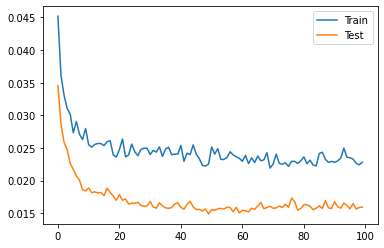

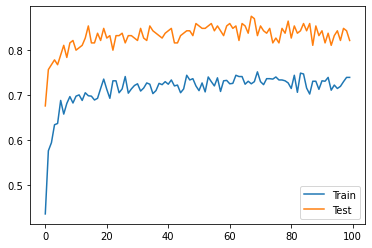

Finish Training
Transfer Learning: no add and train the all layer
Best Acc:0.8756756756756757


In [ ]:
# Model Initial
# Transfer Learning
# {'lr': 0.001, 'gamma': 1.0, 'stepsize': 36}
Resume = False

if Resume:
    model = efficientnetv2_s(num_classes=5)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2.pth')
    model.load_state_dict(model_path)
else:
    # 只训练最后一层，不额外添加新的层
    model = efficientnetv2_s(num_classes=1000)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)
    
    for m in model.parameters():
      m.requires_grad = False

    in_feature = model.head.classifier.in_features
    model.head.classifier = nn.Linear(in_feature, 5)

print(get_parameter_number(model))


model.to(device)
# loss_function = LabelSmoothingLoss(classes=5, smoothing=0.1)
loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)


scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=int(36),
    gamma=1.0  # default is no learning rate decay
)




# Train
epochs = 100
best_acc = 0.0
save_path = './EfficientV2_S_1.pth'
train_steps = len(train_loader)

Resume = False
if Resume == True:
    train_loss=np.load('train_loss.npy')
    train_loss=train_loss.tolist()
    test_loss=np.load('test_loss.npy')
    test_loss=test_loss.tolist()
    train_acc=np.load('train_acc.npy')
    train_acc=train_acc.tolist()
    test_acc=np.load('test_acc.npy')
    test_acc=test_acc.tolist()
else:
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

for epoch in range(epochs):
    # train
    model.train()
    running_loss = 0.0
    Train_acc = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        predict_train_y = torch.max(outputs, dim=1)[1]
        Train_acc += torch.eq(predict_train_y, labels.to(device)).sum().item()
        optimizer.step()

        # print statistcs
        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                  epochs,
                                                                  loss)
    train_loss.append(running_loss/(train_num))
    train_acc.append(Train_acc/(train_num))

    # val
    model.eval()
    acc = 0.0
    test_running_loss = 0.0
    with torch.no_grad():
        val_bar = tqdm(val_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = model(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
            Test_loss = loss_function(outputs, val_labels.to(device))
            test_running_loss += Test_loss.item()

    val_accurate = acc / val_num
    test_loss.append(test_running_loss/val_num)
    test_acc.append(val_accurate)
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(model.state_dict(), save_path)

plt.plot(range(len(train_loss)), train_loss, label='Train')
plt.plot(range(len(test_loss)), test_loss, label='Test')
plt.legend()
plt.show()

plt.plot(range(len(train_acc)), train_acc, label='Train')
plt.plot(range(len(test_acc)), test_acc, label='Test')
plt.legend()
plt.show()
print("Finish Training")
print("Transfer Learning: no add and train the all layer")

print('Best Acc:{}'.format(best_acc))

### Transfer Learning 2:
train all layer

100%|██████████| 6/6 [00:02<00:00,  2.16it/s]
[epoch 1] train_loss: 1.232  val_accuracy: 0.681
100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
[epoch 2] train_loss: 0.923  val_accuracy: 0.843
100%|██████████| 6/6 [00:02<00:00,  2.19it/s]
[epoch 3] train_loss: 0.863  val_accuracy: 0.870
100%|██████████| 6/6 [00:02<00:00,  2.26it/s]
[epoch 4] train_loss: 0.721  val_accuracy: 0.768
100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
[epoch 5] train_loss: 0.739  val_accuracy: 0.838
100%|██████████| 6/6 [00:02<00:00,  2.21it/s]
[epoch 6] train_loss: 0.760  val_accuracy: 0.865
100%|██████████| 6/6 [00:02<00:00,  2.23it/s]
[epoch 7] train_loss: 0.726  val_accuracy: 0.908
100%|██████████| 6/6 [00:02<00:00,  2.22it/s]
[epoch 8] train_loss: 0.621  val_accuracy: 0.865
100%|██████████| 6/6 [00:02<00:00,  2.19it/s]
[epoch 9] train_loss: 0.625  val_accuracy: 0.886
100%|██████████| 6/6 [00:02<00:00,  2.22it/s]
[epoch 10] train_loss: 0.672  val_accuracy: 0.930
100%|██████████| 6/6 [00:02<00:00,  2.19it/s]
[ep

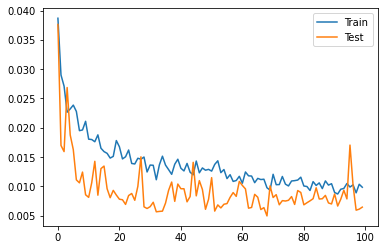

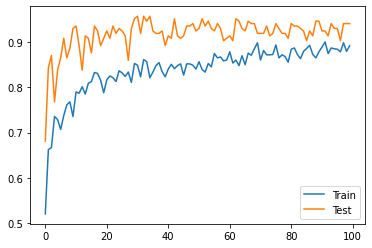

Finish Training
Transfer Learning: no add and train the all layer
Best Acc:0.9567567567567568


In [ ]:
# Model Initial
# Transfer Learning
Resume = False
# {'lr': 0.001677471972645785, 'gamma': 0.9197713528292581, 'stepsize': 34}

if Resume:
    model = efficientnetv2_s(num_classes=5)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2.pth')
    model.load_state_dict(model_path)
else:
    model = efficientnetv2_s(num_classes=1000)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)
    
    in_feature = model.head.classifier.in_features
    model.head.classifier = nn.Linear(in_feature, 5)

# 训练全部网络，不额外添加最后一层
model.to(device)
# loss_function = LabelSmoothingLoss(classes=5, smoothing=0.1)
loss_function = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00057)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001677471972645785)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=int(34),
    gamma=0.9197713528292581  # default is no learning rate decay
)

# Train
epochs = 100
best_acc = 0.0
save_path = './EfficientV2_S_2.pth'
train_steps = len(train_loader)

Resume = False
if Resume == True:
    train_loss=np.load('train_loss.npy')
    train_loss=train_loss.tolist()
    test_loss=np.load('test_loss.npy')
    test_loss=test_loss.tolist()
    train_acc=np.load('train_acc.npy')
    train_acc=train_acc.tolist()
    test_acc=np.load('test_acc.npy')
    test_acc=test_acc.tolist()
else:
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

for epoch in range(epochs):
    # train
    model.train()
    running_loss = 0.0
    Train_acc = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        predict_train_y = torch.max(outputs, dim=1)[1]
        Train_acc += torch.eq(predict_train_y, labels.to(device)).sum().item()
        optimizer.step()

        # print statistcs
        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                  epochs,
                                                                  loss)
    train_loss.append(running_loss/(train_num))
    train_acc.append(Train_acc/(train_num))

    # val
    model.eval()
    acc = 0.0
    test_running_loss = 0.0
    with torch.no_grad():
        val_bar = tqdm(val_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = model(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
            Test_loss = loss_function(outputs, val_labels.to(device))
            test_running_loss += Test_loss.item()

    val_accurate = acc / val_num
    test_loss.append(test_running_loss/val_num)
    test_acc.append(val_accurate)
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(model.state_dict(), save_path)

plt.plot(range(len(train_loss)), train_loss, label='Train')
plt.plot(range(len(test_loss)), test_loss, label='Test')
plt.legend()
plt.show()

plt.plot(range(len(train_acc)), train_acc, label='Train')
plt.plot(range(len(test_acc)), test_acc, label='Test')
plt.legend()
plt.show()
print("Finish Training")
print("Transfer Learning: no add and train the all layer")

print('Best Acc:{}'.format(best_acc))

### Transfer Learning 3:
(1)train all layer
(2)add a new layer

100%|██████████| 6/6 [00:02<00:00,  2.21it/s]
[epoch 1] train_loss: 1.093  val_accuracy: 0.870
100%|██████████| 6/6 [00:02<00:00,  2.21it/s]
[epoch 2] train_loss: 0.827  val_accuracy: 0.838
100%|██████████| 6/6 [00:02<00:00,  2.28it/s]
[epoch 3] train_loss: 0.703  val_accuracy: 0.897
100%|██████████| 6/6 [00:02<00:00,  2.26it/s]
[epoch 4] train_loss: 0.652  val_accuracy: 0.897
100%|██████████| 6/6 [00:02<00:00,  2.24it/s]
[epoch 5] train_loss: 0.598  val_accuracy: 0.935
100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
[epoch 6] train_loss: 0.673  val_accuracy: 0.897
100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
[epoch 7] train_loss: 0.601  val_accuracy: 0.897
100%|██████████| 6/6 [00:02<00:00,  2.24it/s]
[epoch 8] train_loss: 0.571  val_accuracy: 0.935
100%|██████████| 6/6 [00:02<00:00,  2.26it/s]
[epoch 9] train_loss: 0.564  val_accuracy: 0.892
100%|██████████| 6/6 [00:02<00:00,  2.29it/s]
[epoch 10] train_loss: 0.546  val_accuracy: 0.919
100%|██████████| 6/6 [00:02<00:00,  2.23it/s]
[ep

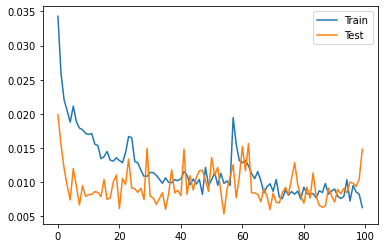

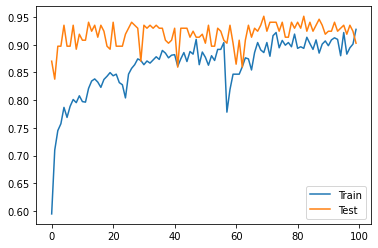

Finish Training
Transfer Learning: no add and train the all layer
Best Acc:0.9513513513513514


In [ ]:
# Model Initial
# Transfer Learning
# {'lr': 0.001, 'gamma': 0.9632942980873643, 'stepsize': 20}
Resume = False

if Resume:
    model = efficientnetv2_s(num_classes=119)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)
else:
    # 训练全部网络，增加最后一层
    model = efficientnetv2_s(num_classes=1000)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)
    model.head.classifier = nn.Sequential(
        nn.Linear(in_features=1280, out_features=1000, bias=True),
        nn.Linear(in_features=1000, out_features=5, bias = True)
    )

model.to(device)
# loss_function = LabelSmoothingLoss(classes=5, smoothing=0.1)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=int(20),
    gamma= 0.963294298087364  # default is no learning rate decay
)



# Train
epochs = 100
best_acc = 0.0
save_path = './EfficientV2_S_3.pth'
train_steps = len(train_loader)

Resume = False
if Resume == True:
    train_loss=np.load('train_loss.npy')
    train_loss=train_loss.tolist()
    test_loss=np.load('test_loss.npy')
    test_loss=test_loss.tolist()
    train_acc=np.load('train_acc.npy')
    train_acc=train_acc.tolist()
    test_acc=np.load('test_acc.npy')
    test_acc=test_acc.tolist()
else:
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

for epoch in range(epochs):
    # train
    model.train()
    running_loss = 0.0
    Train_acc = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        predict_train_y = torch.max(outputs, dim=1)[1]
        Train_acc += torch.eq(predict_train_y, labels.to(device)).sum().item()
        optimizer.step()

        # print statistcs
        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                  epochs,
                                                                  loss)
    train_loss.append(running_loss/(train_num))
    train_acc.append(Train_acc/(train_num))

    # val
    model.eval()
    acc = 0.0
    test_running_loss = 0.0
    with torch.no_grad():
        val_bar = tqdm(val_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = model(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
            Test_loss = loss_function(outputs, val_labels.to(device))
            test_running_loss += Test_loss.item()

    val_accurate = acc / val_num
    test_loss.append(test_running_loss/val_num)
    test_acc.append(val_accurate)
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(model.state_dict(), save_path)

plt.plot(range(len(train_loss)), train_loss, label='Train')
plt.plot(range(len(test_loss)), test_loss, label='Test')
plt.legend()
plt.show()

plt.plot(range(len(train_acc)), train_acc, label='Train')
plt.plot(range(len(test_acc)), test_acc, label='Test')
plt.legend()
plt.show()
print("Finish Training")
print("Transfer Learning: no add and train the all layer")

print('Best Acc:{}'.format(best_acc))

### Transfer Learning 4:
(1)train last layer
(2)add a new layer

100%|██████████| 6/6 [00:02<00:00,  2.30it/s]
[epoch 1] train_loss: 1.349  val_accuracy: 0.849
100%|██████████| 6/6 [00:03<00:00,  1.73it/s]
[epoch 2] train_loss: 0.816  val_accuracy: 0.897
100%|██████████| 6/6 [00:02<00:00,  2.30it/s]
[epoch 3] train_loss: 0.611  val_accuracy: 0.946
100%|██████████| 6/6 [00:02<00:00,  2.29it/s]
[epoch 4] train_loss: 0.516  val_accuracy: 0.946
100%|██████████| 6/6 [00:02<00:00,  2.33it/s]
[epoch 5] train_loss: 0.444  val_accuracy: 0.951
100%|██████████| 6/6 [00:02<00:00,  2.28it/s]
[epoch 6] train_loss: 0.434  val_accuracy: 0.951
100%|██████████| 6/6 [00:02<00:00,  2.12it/s]
[epoch 7] train_loss: 0.389  val_accuracy: 0.941
100%|██████████| 6/6 [00:02<00:00,  2.23it/s]
[epoch 8] train_loss: 0.369  val_accuracy: 0.946
100%|██████████| 6/6 [00:02<00:00,  2.31it/s]
[epoch 9] train_loss: 0.359  val_accuracy: 0.941
100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
[epoch 10] train_loss: 0.337  val_accuracy: 0.946
100%|██████████| 6/6 [00:03<00:00,  1.97it/s]
[ep

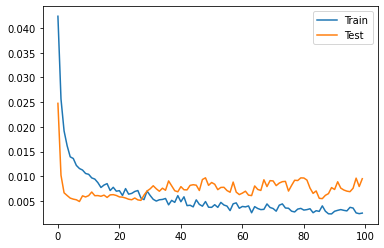

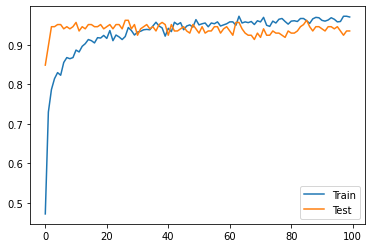

Finish Training
Transfer Learning: no add and train the all layer
Best Acc:0.9621621621621622


In [ ]:
# Model Initial
# Transfer Learning
# {'lr': 8.114888995978981e-05, 'gamma': 0.9338897386565804, 'stepsize': 30}

Resume = False

if Resume:
    model = efficientnetv2_s(num_classes=119)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)
else:

    # 训练最后一层，额外添加一层
    model = efficientnetv2_s(num_classes=1000)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)

    for m in model.parameters():
      m.grad_require = False
    model.head.classifier = nn.Sequential(
        nn.Linear(in_features=1280, out_features=1000, bias=True),
        nn.Linear(in_features=1000, out_features=5, bias = True)
    )

# model.head.classifier.
model.to(device)
# loss_function = LabelSmoothingLoss(classes=5, smoothing=0.1)
loss_function = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

optimizer = optim.Adam(model.parameters(), # or any optimizer you prefer 
                      lr=8.114888995978981e-05) # 0.001 is used if no lr is specified


scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=int(30),
    gamma=0.9338897386565804,  # default is no learning rate decay
)


# Train
epochs = 100
best_acc = 0.0
save_path = './EfficientV2_S_4.pth'
train_steps = len(train_loader)

Resume = False
if Resume == True:
    train_loss=np.load('train_loss.npy')
    train_loss=train_loss.tolist()
    test_loss=np.load('test_loss.npy')
    test_loss=test_loss.tolist()
    train_acc=np.load('train_acc.npy')
    train_acc=train_acc.tolist()
    test_acc=np.load('test_acc.npy')
    test_acc=test_acc.tolist()
else:
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

for epoch in range(epochs):
    # train
    model.train()
    running_loss = 0.0
    Train_acc = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        predict_train_y = torch.max(outputs, dim=1)[1]
        Train_acc += torch.eq(predict_train_y, labels.to(device)).sum().item()
        optimizer.step()

        # print statistcs
        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                  epochs,
                                                                  loss)
    train_loss.append(running_loss/(train_num))
    train_acc.append(Train_acc/(train_num))

    # val
    model.eval()
    acc = 0.0
    test_running_loss = 0.0
    with torch.no_grad():
        val_bar = tqdm(val_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = model(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
            Test_loss = loss_function(outputs, val_labels.to(device))
            test_running_loss += Test_loss.item()

    val_accurate = acc / val_num
    test_loss.append(test_running_loss/val_num)
    test_acc.append(val_accurate)
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(model.state_dict(), save_path)

plt.plot(range(len(train_loss)), train_loss, label='Train')
plt.plot(range(len(test_loss)), test_loss, label='Test')
plt.legend()
plt.show()

plt.plot(range(len(train_acc)), train_acc, label='Train')
plt.plot(range(len(test_acc)), test_acc, label='Test')
plt.legend()
plt.show()
print("Finish Training")
print("Transfer Learning: no add and train the all layer")

print('Best Acc:{}'.format(best_acc))

In [ ]:
# Add New Layer, Train All:  0.962 -> 0.
# Add New Layer, Train Last: 0.962 -> 0.
# No Add,        Train All:  0.97  -> 0. 
# No Add,        Train Last: 0.84  -> 0.

## Loss Function = LabelSmoothing

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1, weight = None):
        """if smoothing == 0, it's one-hot method
           if 0 < smoothing < 1, it's smooth method
        """
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.weight = weight
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        assert 0 <= self.smoothing < 1
        pred = pred.log_softmax(dim=self.dim)

        if self.weight is not None:
            pred = pred * self.weight.unsqueeze(0)   

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
def init_net(parameterization):

    # 训练最后一层，额外添加一层
    model = efficientnetv2_s(num_classes=1000)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)

    for m in model.parameters():
      m.grad_require = False
    model.head.classifier = nn.Sequential(
        nn.Linear(in_features=1280, out_features=1000, bias=True),
        nn.Linear(in_features=1000, out_features=5, bias = True)
    )

    return model # return untrained model

In [ ]:
def train_evaluate(parameterization):


    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=2,
                                pin_memory=True)
    
    # Get neural net
    untrained_net = init_net(parameterization) 
    
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=val_loader,
        dtype=dtype,
        device=device,
    )

In [ ]:
def net_train(net, train_loader, parameters, dtype, device):
  net.to(dtype=dtype, device=device)


  # Define loss and optimizer
  # criterion = nn.CrossEntropyLoss()
  criterion = LabelSmoothingLoss(classes=5, smoothing = parameters.get("smoothing", 0.9))
  optimizer = optim.Adam(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001) # 0.001 is used if no lr is specified
  )


  # scheduler = optim.lr_scheduler.StepLR(
  #     optimizer,
  #     step_size=int(parameters.get("step_size", 20)),
  #     gamma=parameters.get("gamma", 1.0),  # default is no learning rate decay
  # )


  num_epochs = parameters.get("num_epochs", 70) # Play around with epoch number
  # Train Network
  for _ in range(num_epochs):
      for inputs, labels in train_loader:
          # move data to proper dtype and device
          inputs = inputs.to(dtype=dtype, device=device)
          labels = labels.to(device=device)


          # zero the parameter gradients
          optimizer.zero_grad()


          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          scheduler.step()
  return net

In [ ]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# {'lr': 0.001677471972645785, 'gamma': 0.9197713528292581, 'stepsize': 34}

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 1e-4]},
        # {"name": "gamma", "type": "range", "bounds": [0.9, 1.0]},
        # {"name": "stepsize", "type": "range", "bounds": [25, 35]}, 
        {"name": "smoothing", "type": "range", "bounds": [0.1, 1.0]}  
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)


print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 04-25 17:25:09] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-25 17:25:09] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter smoothing. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-25 17:25:09] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[1e-06, 0.0001]), RangeParameter(name='smoothing', parameter_type=FLOAT, range=[0.1, 1.0])], parameter_constraints=[]).
[INFO 04-25 17:25:09] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 04-25 17:25:09] ax.modelbridge

{'lr': 8.653496412839741e-05, 'smoothing': 0.6085345120169222}
{'accuracy': 0.9675675675675676}
{'accuracy': {'accuracy': nan}}


100%|██████████| 6/6 [00:24<00:00,  4.13s/it]
[epoch 1] train_loss: 1.607  val_accuracy: 0.762
100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
[epoch 2] train_loss: 1.574  val_accuracy: 0.892
100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
[epoch 3] train_loss: 1.561  val_accuracy: 0.924
100%|██████████| 6/6 [00:02<00:00,  2.21it/s]
[epoch 4] train_loss: 1.556  val_accuracy: 0.908
100%|██████████| 6/6 [00:02<00:00,  2.22it/s]
[epoch 5] train_loss: 1.551  val_accuracy: 0.924
100%|██████████| 6/6 [00:02<00:00,  2.19it/s]
[epoch 6] train_loss: 1.550  val_accuracy: 0.941
100%|██████████| 6/6 [00:02<00:00,  2.26it/s]
[epoch 7] train_loss: 1.547  val_accuracy: 0.941
100%|██████████| 6/6 [00:02<00:00,  2.26it/s]
[epoch 8] train_loss: 1.546  val_accuracy: 0.930
100%|██████████| 6/6 [00:02<00:00,  2.21it/s]
[epoch 9] train_loss: 1.543  val_accuracy: 0.935
100%|██████████| 6/6 [00:02<00:00,  2.22it/s]
[epoch 10] train_loss: 1.543  val_accuracy: 0.930


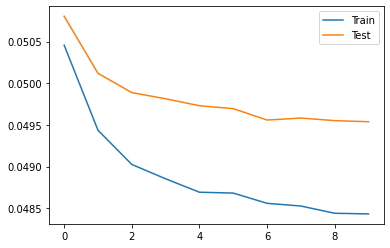

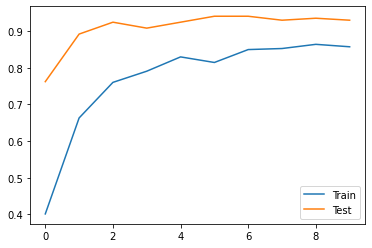

Finish Training
Transfer Learning: no add and train the all layer
Best Acc:0.9405405405405406


In [ ]:
# Model Initial
# Transfer Learning
# {'lr': 7.218473436968366e-05, 'gamma': 1.0, 'stepsize': 35, 'smoothing': 0.27334109448508925}
Resume = False

if Resume:
    model = efficientnetv2_s(num_classes=119)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)
else:

    # 训练最后一层，额外添加一层
    model = efficientnetv2_s(num_classes=1000)
    model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
    model.load_state_dict(model_path)

    for m in model.parameters():
      m.grad_require = False
    model.head.classifier = nn.Sequential(
        nn.Linear(in_features=1280, out_features=1000, bias=True),
        nn.Linear(in_features=1000, out_features=5, bias = True)
    )

# model.head.classifier.
model.to(device)
loss_function = LabelSmoothingLoss(classes=5, smoothing=0.6085)
# loss_function = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

optimizer = optim.Adam(model.parameters(), # or any optimizer you prefer 
                      lr=8.653496412839741e-05) # 0.001 is used if no lr is specified


scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=int(35),
    gamma=1.0,  # default is no learning rate decay
)


# Train
epochs = 10
best_acc = 0.0
save_path = './EfficientV2_S_5.pth'
train_steps = len(train_loader)

Resume = False
if Resume == True:
    train_loss=np.load('train_loss.npy')
    train_loss=train_loss.tolist()
    test_loss=np.load('test_loss.npy')
    test_loss=test_loss.tolist()
    train_acc=np.load('train_acc.npy')
    train_acc=train_acc.tolist()
    test_acc=np.load('test_acc.npy')
    test_acc=test_acc.tolist()
else:
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

for epoch in range(epochs):
    # train
    model.train()
    running_loss = 0.0
    Train_acc = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        predict_train_y = torch.max(outputs, dim=1)[1]
        Train_acc += torch.eq(predict_train_y, labels.to(device)).sum().item()
        optimizer.step()

        # print statistcs
        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                  epochs,
                                                                  loss)
    train_loss.append(running_loss/(train_num))
    train_acc.append(Train_acc/(train_num))

    # val
    model.eval()
    acc = 0.0
    test_running_loss = 0.0
    with torch.no_grad():
        val_bar = tqdm(val_loader, file=sys.stdout)
        for val_data in val_bar:
            val_images, val_labels = val_data
            outputs = model(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
            Test_loss = loss_function(outputs, val_labels.to(device))
            test_running_loss += Test_loss.item()

    val_accurate = acc / val_num
    test_loss.append(test_running_loss/val_num)
    test_acc.append(val_accurate)
    print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
          (epoch + 1, running_loss / train_steps, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(model.state_dict(), save_path)

plt.plot(range(len(train_loss)), train_loss, label='Train')
plt.plot(range(len(test_loss)), test_loss, label='Test')
plt.legend()
plt.show()

plt.plot(range(len(train_acc)), train_acc, label='Train')
plt.plot(range(len(test_acc)), test_acc, label='Test')
plt.legend()
plt.show()
print("Finish Training")
print("Transfer Learning: no add and train the all layer")

print('Best Acc:{}'.format(best_acc))

100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


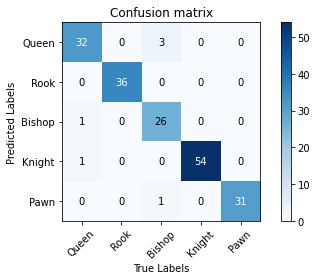

the model accuracy is  0.9675675675675676
+--------+-----------+--------+-------------+
|        | Precision | Recall | Specificity |
+--------+-----------+--------+-------------+
| Queen  |   0.914   | 0.941  |     0.98    |
|  Rook  |    1.0    |  1.0   |     1.0     |
| Bishop |   0.963   | 0.867  |    0.994    |
| Knight |   0.982   |  1.0   |    0.992    |
|  Pawn  |   0.969   |  1.0   |    0.994    |
+--------+-----------+--------+-------------+


In [ ]:
# Label = [key.split('-')[0] for key, value in train_dataset.class_to_idx.items()]
Label = ['Queen', 'Rook', 'Bishop', 'Knight', 'Pawn']
confusion = ConfusionMatrix(num_classes=5, labels=Label)

model = efficientnetv2_s(num_classes=1000)

for m in model.parameters():
  m.grad_require = False
model.head.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=1000, bias=True),
    nn.Linear(in_features=1000, out_features=5, bias = True)
)
Wrong_image = []
Wrong_label = []
model_path = torch.load('/content/EfficientV2_S_5.pth')
# model_path = torch.load('/content/drive/MyDrive/pre_efficientnetv2-s.pth')
model.load_state_dict(model_path)

model.to(device)
model.eval()

with torch.no_grad():
    val_bar = tqdm(val_loader, file=sys.stdout)
    for val_data in val_bar:
        val_images, val_labels = val_data
        outputs = model(val_images.to(device))
        predict_y = torch.max(outputs, dim=1)[1]
        confusion.update(predict_y, val_labels)
        for i in range(len(predict_y)):
          if predict_y[i] != val_labels[i]:
            Wrong_image.append(val_images[i,:,:,:].permute([1,2,0]))
            Wrong_label.append([predict_y[i],val_labels[i]])

# Confusion Matrix Visualizatoin
confusion.plot()
confusion.summary()

## Inference

class: Queen-Resized   prob: 0.134
class: Rook-resize   prob: 0.138
class: bishop_resized   prob: 0.117
class: knight-resize   prob: 0.458
class: pawn_resized   prob: 0.153


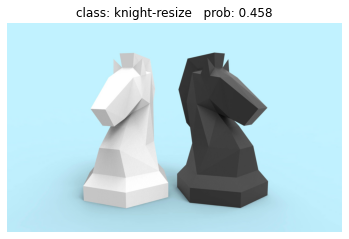

In [ ]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

def inference(img_path,json_path,model_weight_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform_png = transforms.Compose(
        [transforms.Resize((384, 384)),
         transforms.ToTensor(),
         transforms.Normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
         ])
    data_transform_jpg = transforms.Compose(
        [transforms.Resize((384, 384)),
         transforms.ToTensor(),
         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

    # load image
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    channel = len(img.split())
    if channel not in [3, 4]:
        return print('Image Channel is not Match, the channel is {}'.format(channel))
    # [N, C, H, W]
    plt.imshow(img)
    if channel == 4:
        img = data_transform_png(img)
        img = img[0:3, :, :]
    else:
        img = data_transform_jpg(img)
    # expand batch dimension
    img = torch.unsqueeze(img, dim=0)

    # read class_indict
    assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

    json_file = open(json_path, "r")
    class_indict = json.load(json_file)

    # create model
    model = efficientnetv2_s(num_classes=5).to(device)
    model.head.classifier = nn.Sequential(
    nn.Linear(in_features=1280, out_features=1000, bias=True),
    nn.Linear(in_features=1000, out_features=5, bias = True))
    model.to(device)
    # load model weights
    model.load_state_dict(torch.load(model_weight_path, map_location=device))
    model.eval()
    with torch.no_grad():
        # predict class
        output = torch.squeeze(model(img.to(device))).cpu()
        predict = torch.softmax(output, dim=0)
        predict_cla = torch.argmax(predict).numpy()

    print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                 predict[predict_cla].numpy())
    plt.title(print_res)
    for i in range(len(predict)):
        print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                  predict[i].numpy()))
    plt.axis('off')
    plt.show()


if __name__ == '__main__':
    inference(img_path = "/content/5_afc0ee4a54ed24867b79ef3e09395577.jpeg",
              json_path = './class_label.json',
              model_weight_path = "./EfficientV2_S_5.pth")

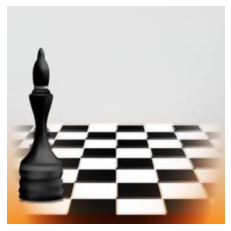

Predicted Label is bishop_resized, Actual Label is Queen-Resized


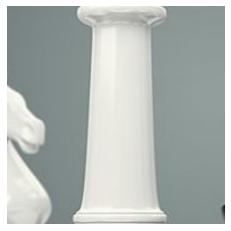

Predicted Label is knight-resize, Actual Label is Queen-Resized


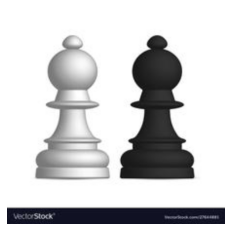

Predicted Label is pawn_resized, Actual Label is bishop_resized


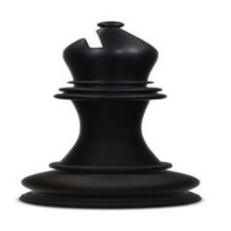

Predicted Label is Queen-Resized, Actual Label is bishop_resized


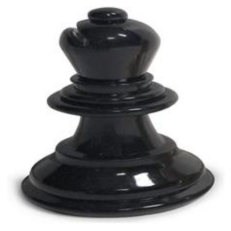

Predicted Label is Queen-Resized, Actual Label is bishop_resized


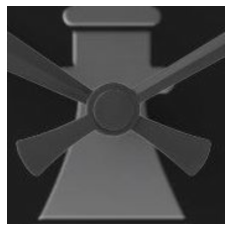

Predicted Label is Queen-Resized, Actual Label is bishop_resized


In [ ]:
# MisClassification Visualization
import time
for i in range(len(Wrong_label)):
  image = (Wrong_image[i].numpy())*0.5 + 0.5
  plt.figure(); plt.imshow(image); plt.axis('off');plt.show()
  print('Predicted Label is {}, Actual Label is {}'.format(label_to_category[int(Wrong_label[i][0].cpu().numpy())],
                                                           label_to_category[int(Wrong_label[i][1])]))
  # plt.imshow(image)